In [1]:
import json
import numpy as np
import random
import sys
from tqdm import tqdm
import re
from pathlib import Path

import torch
import torch.nn as nn
from transformers import DistilBertModel, DistilBertTokenizer

from wikidataintegrator import wdi_core
from wikidata.client import Client
import wikidata
import en_core_web_sm
nlp = en_core_web_sm.load()

from IPython.display import clear_output
from IPython.core.debugger import set_trace
import matplotlib.pyplot as plt
%matplotlib inline

#############################################################
from utils import get_triplets_by_idd, get_description_name
from datasets import load_rubq, load_simple_questions, combined_dataset
from models import EncoderBERT, get_projection_module_simple, get_tokenizer
from reject import reject_by_metric
from train import train_ensemble
from eval_models import eval_ensemble

%load_ext autoreload
%autoreload 1

2022-08-03 06:42:47.522748: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-08-03 06:42:47.527324: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-08-03 06:42:47.527347: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(m

In [2]:
device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")
print(device)

cuda:5


### Loading Graph Embeddings and Questions

In [3]:
#path to full list of embeddings and full list of ids (one2one correspondence with embeddings)
PATH_TO_EMBEDDINGS_Q = "../new_data/entitie_embeddings_ru.json" 
PATH_TO_IDS = "../new_data/entitie_ids_ru_filtered.json"
PATH_TO_EMBEDDINGS_P = "../new_data/entitie_P_embeddings_ru.json" 

graph_embeddings_Q = json.load(open(PATH_TO_EMBEDDINGS_Q))
graph_embeddings_P = json.load(open(PATH_TO_EMBEDDINGS_P))

In [4]:
%autoreload

MASTER_SEED = 42

questions_train, relations_train, entities_train, answers_train, questions_val, relations_val, entities_val, answers_val, questions_test, answers_test = load_rubq(MASTER_SEED, graph_embeddings_Q, graph_embeddings_P)
simple_questions_train, simple_questions_val = load_simple_questions(MASTER_SEED, graph_embeddings_Q, graph_embeddings_P)

/notebook/meker/KBQA/datasets.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  answers_train = np.array(answers)[train_ids]
/notebook/meker/KBQA/datasets.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  answers_val = np.array(answers)[val_ids]


308
296
1186
16414


100% 16414/16414 [00:00<00:00, 188951.69it/s]

8327


### Dataset and Dataloaders

In [5]:
%autoreload

train_dataset = combined_dataset(questions_train, answers_train, entities_train, relations_train, graph_embeddings_Q, graph_embeddings_P, simple_questions_train, device)
val_dataset = combined_dataset(questions_val, answers_val, entities_val, relations_val, graph_embeddings_Q, graph_embeddings_P, simple_questions_val, device)

val_dataloader = torch.utils.data.DataLoader(val_dataset,batch_size=64, shuffle=False)

### Load pretrained model

In [7]:
%autoreload

loss = nn.CosineEmbeddingLoss()
loss_name = str(loss)[:-2]
proj_hidden_size = 512

models_path = Path(f'./models/{loss_name}_{proj_hidden_size}_no_regularization/')
models_path.mkdir(parents=True, exist_ok=True)

N_MODELS = 5
proj_hidden_size = 512

de_models = []
for i in range(N_MODELS):
    encoder = EncoderBERT(device)
    projection_E = get_projection_module_simple(device, proj_hidden_size)
    projection_Q = get_projection_module_simple(device, proj_hidden_size)
    projection_P = get_projection_module_simple(device, proj_hidden_size)

    encoder.load_state_dict(torch.load(models_path / f'encoder_{i}.pt'))
    projection_E.load_state_dict(torch.load(models_path / f'projection_E_{i}.pt'))
    projection_Q.load_state_dict(torch.load(models_path / f'projection_Q_{i}.pt'))
    projection_P.load_state_dict(torch.load(models_path / f'projection_P_{i}.pt'))
    
    de_models.append({'encoder': encoder, 'projection_P': projection_P, 'projection_Q': projection_Q, 'projection_E': projection_E})

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.Laye

### Load DB graph

In [8]:
embeddings_Q = graph_embeddings_Q
ids_list = list(graph_embeddings_Q.keys())
embeddings_Q = [embeddings_Q[Q] for Q in ids_list]
embeddings_tensor_Q = torch.FloatTensor(embeddings_Q)

embeddings_P = graph_embeddings_P
embeddings_P = [embeddings_P[P] for P in graph_embeddings_P.keys()]
embeddings_tensor_P = torch.FloatTensor(embeddings_P)

## Eval

### RuBQ

In [9]:
candidates = list(np.load("./data/presearched_fixed_rubq_test.npy", allow_pickle=True))

### Eval ensemble

In [73]:
%autoreload

q_list, a_list, a_predicts, inv_ranks, top1_scores, top2_scores, e_stds, q_stds, p_stds, e_stds_norm, q_stds_norm, p_stds_norm, cosines_stds, entropies_of_mean, mean_entropies, acc, cosines_P_stds, cosines_Q_stds, cosines_E_stds, bad_question_ids, all_cosines, a_model_predicts = eval_ensemble(questions_test, answers_test, graph_embeddings_P, graph_embeddings_Q, candidates, de_models, device, entropy_limit=5)

0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


> /notebook/meker/KBQA/eval_models.py(213)eval_ensemble()
    211                         if num_opinions > 1:
    212                             set_trace()
--> 213                             pass
    214 
    215                 else:



ipdb>  entropies_of_mean[-1]


1.0755587


ipdb>  mean_entropies[-1]


0.6082374


ipdb>  exit


0it [00:20, ?it/s]


In [11]:
incorrect_predictions_mask = np.full_like(a_predicts, False)
incorrect_predictions_mask[np.array(inv_ranks) != 1.0] = True
incorrect_predictions_mask = incorrect_predictions_mask.astype(bool)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [12]:
bad_questions_mask = np.full_like(a_predicts, True)
bad_questions_mask[bad_question_ids] = False
bad_questions_mask = bad_questions_mask.astype(bool)

### All predictions

In [13]:
preds_with_differing_opinions = []
number_of_opinions = []

for model_preds in np.array(a_model_predicts)[bad_questions_mask]:
    first_preds = [pred[0] for pred in model_preds]
    num_opinions = len(set(first_preds))
    number_of_opinions.append(num_opinions)
    preds_with_differing_opinions.append(num_opinions > 1)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.


In [14]:
np.mean(preds_with_differing_opinions)

0.4422560429722471

(array([623.,   0., 288.,   0.,   0., 153.,   0.,  44.,   0.,   9.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

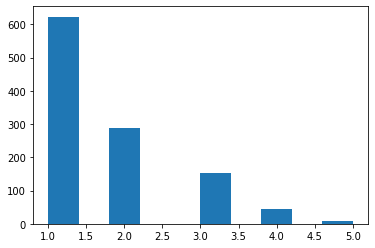

In [15]:
plt.hist(number_of_opinions)

#### Average pairwise Hamming distance

In [16]:
from scipy.spatial.distance import hamming
from itertools import combinations

distances = []

for model_preds in np.array(a_model_predicts)[bad_questions_mask]:
    pred_distances = []
    for i, j in combinations(range(5), 2):
        pred_distances.append(hamming(model_preds[i], model_preds[j]))
    distances.append(np.mean(pred_distances))

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [17]:
np.mean(distances)

0.7727740553267703

### Incorrect predictions

In [18]:
incorrect_preds_with_differing_opinions = []
number_of_incorrect_opinions = []

for model_preds in np.array(a_model_predicts)[bad_questions_mask & incorrect_predictions_mask]:
    first_preds = [pred[0] for pred in model_preds]
    num_opinons = len(set(first_preds))
    number_of_incorrect_opinions.append(num_opinons)
    incorrect_preds_with_differing_opinions.append(num_opinons > 1)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.


In [19]:
np.mean(incorrect_preds_with_differing_opinions)

0.6914498141263941

(array([166.,   0., 194.,   0.,   0., 128.,   0.,  41.,   0.,   9.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

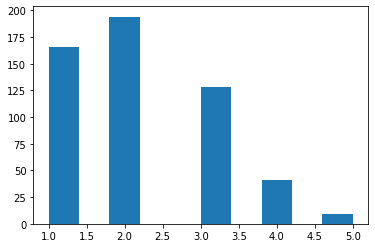

In [20]:
plt.hist(number_of_incorrect_opinions)

#### Average pairwise Hamming distance

In [21]:
from scipy.spatial.distance import hamming
from itertools import combinations

incorrect_distances = []

for model_preds in np.array(a_model_predicts)[bad_questions_mask & incorrect_predictions_mask]:
    pred_distances = []
    for i, j in combinations(range(5), 2):
        pred_distances.append(hamming(model_preds[i], model_preds[j]))
    incorrect_distances.append(np.mean(pred_distances))

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [22]:
np.mean(incorrect_distances)

0.8375817455732602

### Simple Questions

In [23]:
import pickle

entities = np.load('data/candidate_entities_sq_test.npy', allow_pickle=True)

with open('data/entity_subgraphs_sq_test.pickle', 'rb') as handle:
    entity_subgraphs = pickle.load(handle)

In [24]:
sq_candidates = []

for question_entities in entities:
    candidates_dict = {}
    for entity in list(question_entities.item()):
        candidates_dict[entity] = entity_subgraphs[entity]
    sq_candidates.append(candidates_dict)

In [25]:
simple_questions_test = np.load("../new_data/simple_questions_test.npy")

simple_questions_filtered = []
questions_sq = []
answers_sq = []

for e, p, a, q in tqdm(simple_questions_test):
    if e in graph_embeddings_Q and a in graph_embeddings_Q and p in graph_embeddings_P:
        simple_questions_filtered.append((e, p, a, q))
        questions_sq.append(q)
        answers_sq.append([a])

100% 4751/4751 [00:00<00:00, 187881.98it/s]


In [26]:
%autoreload

q_list, a_list, a_predicts, inv_ranks, top1_scores, top2_scores, e_stds, q_stds, p_stds, e_stds_norm, q_stds_norm, p_stds_norm, cosines_stds, entropies_of_mean, mean_entropies, acc, cosines_P_stds, cosines_Q_stds, cosines_E_stds, bad_question_ids, all_cosines, a_model_predicts = eval_ensemble(questions_sq, answers_sq, graph_embeddings_P, graph_embeddings_Q, sq_candidates, de_models, device)

0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
2438it [02:16, 17.87it/s]

Accuracy:  0.5311730926989335


In [27]:
incorrect_predictions_mask = np.full_like(a_predicts, False)
incorrect_predictions_mask[np.array(inv_ranks) != 1.0] = True
incorrect_predictions_mask = incorrect_predictions_mask.astype(bool)

In [28]:
bad_questions_mask = np.full_like(a_predicts, True)
bad_questions_mask[bad_question_ids] = False
bad_questions_mask = bad_questions_mask.astype(bool)

### All predictions

In [29]:
preds_with_differing_opinions = []
number_of_opinions = []

for model_preds in np.array(a_model_predicts)[bad_questions_mask]:
    first_preds = [pred[0] for pred in model_preds]
    num_opinons = len(set(first_preds))
    number_of_opinions.append(num_opinons)
    preds_with_differing_opinions.append(num_opinons > 1)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.


In [30]:
np.mean(preds_with_differing_opinions)

0.27358490566037735

(array([1771.,    0.,  519.,    0.,    0.,  117.,    0.,   23.,    0.,
           8.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

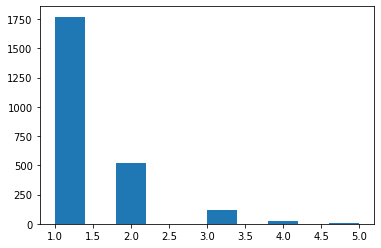

In [31]:
plt.hist(number_of_opinions)

#### Average pairwise Hamming distance

In [32]:
from scipy.spatial.distance import hamming
from itertools import combinations

distances = []

for model_preds in np.array(a_model_predicts)[bad_questions_mask]:
    pred_distances = []
    for i, j in combinations(range(5), 2):
        pred_distances.append(hamming(model_preds[i], model_preds[j]))
    distances.append(np.mean(pred_distances))

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [33]:
np.mean(distances)

0.791792351731504

### Incorrect predictions

In [34]:
incorrect_preds_with_differing_opinions = []
number_of_incorrect_opinions = []

for model_preds in np.array(a_model_predicts)[bad_questions_mask & incorrect_predictions_mask]:
    first_preds = [pred[0] for pred in model_preds]
    num_opinons = len(set(first_preds))
    number_of_incorrect_opinions.append(num_opinons)
    incorrect_preds_with_differing_opinions.append(num_opinons > 1)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.


In [35]:
np.mean(incorrect_preds_with_differing_opinions)

0.4444444444444444

(array([635.,   0., 370.,   0.,   0., 107.,   0.,  23.,   0.,   8.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

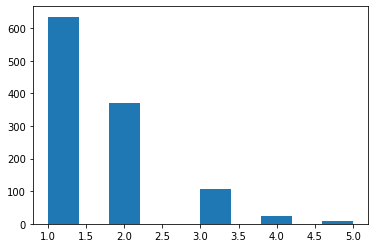

In [36]:
plt.hist(number_of_incorrect_opinions)

#### Average pairwise Hamming distance

In [37]:
from scipy.spatial.distance import hamming
from itertools import combinations

incorrect_distances = []

for model_preds in np.array(a_model_predicts)[bad_questions_mask & incorrect_predictions_mask]:
    pred_distances = []
    for i, j in combinations(range(5), 2):
        pred_distances.append(hamming(model_preds[i], model_preds[j]))
    incorrect_distances.append(np.mean(pred_distances))

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [38]:
np.mean(incorrect_distances)

0.8034492183692907

## MC Dropout ensemble

In [39]:
N_MODELS = 10

mc_models = []

for _ in range(N_MODELS):
    base_model = de_models[0]
    mc_models.append({'encoder': base_model['encoder'], 
                      'projection_P': base_model['projection_P'], 
                      'projection_Q': base_model['projection_Q'], 
                      'projection_E': base_model['projection_E'], 
                      'dropout_mask': True})

## Eval

### RuBQ

In [40]:
candidates = list(np.load("./data/presearched_fixed_rubq_test.npy", allow_pickle=True))

### Eval ensemble

In [41]:
%autoreload

q_list, a_list, a_predicts, inv_ranks, top1_scores, top2_scores, e_stds, q_stds, p_stds, e_stds_norm, q_stds_norm, p_stds_norm, cosines_stds, entropies_of_mean, mean_entropies, acc, cosines_P_stds, cosines_Q_stds, cosines_E_stds, bad_question_ids, all_cosines, a_model_predicts = eval_ensemble(questions_test, answers_test, graph_embeddings_P, graph_embeddings_Q, candidates, mc_models, device)

0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1186it [01:54, 10.39it/s]

Accuracy:  0.48903878583473864


In [42]:
incorrect_predictions_mask = np.full_like(a_predicts, False)
incorrect_predictions_mask[np.array(inv_ranks) != 1.0] = True
incorrect_predictions_mask = incorrect_predictions_mask.astype(bool)

In [43]:
bad_questions_mask = np.full_like(a_predicts, True)
bad_questions_mask[bad_question_ids] = False
bad_questions_mask = bad_questions_mask.astype(bool)

### All predictions

In [44]:
preds_with_differing_opinions = []
number_of_opinions = []

for model_preds in np.array(a_model_predicts)[bad_questions_mask]:
    first_preds = [pred[0] for pred in model_preds]
    num_opinons = len(set(first_preds))
    number_of_opinions.append(num_opinons)
    preds_with_differing_opinions.append(num_opinons > 1)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.


In [45]:
np.mean(preds_with_differing_opinions)

0.4968666069829902

(array([562., 241., 136.,   0.,  73.,  55.,   0.,  34.,  12.,   4.]),
 array([1. , 1.7, 2.4, 3.1, 3.8, 4.5, 5.2, 5.9, 6.6, 7.3, 8. ]),
 <BarContainer object of 10 artists>)

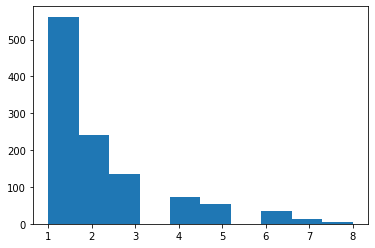

In [46]:
plt.hist(number_of_opinions)

#### Average pairwise Hamming distance

In [47]:
from scipy.spatial.distance import hamming
from itertools import combinations

distances = []

for model_preds in np.array(a_model_predicts)[bad_questions_mask]:
    pred_distances = []
    for i, j in combinations(range(10), 2):
        pred_distances.append(hamming(model_preds[i], model_preds[j]))
    distances.append(np.mean(pred_distances))

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [48]:
np.mean(distances)

0.8264095538544404

### Incorrect predictions

In [49]:
incorrect_preds_with_differing_opinions = []
number_of_incorrect_opinions = []

for model_preds in np.array(a_model_predicts)[bad_questions_mask & incorrect_predictions_mask]:
    first_preds = [pred[0] for pred in model_preds]
    num_opinons = len(set(first_preds))
    number_of_incorrect_opinions.append(num_opinons)
    incorrect_preds_with_differing_opinions.append(num_opinons > 1)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.


In [50]:
np.mean(incorrect_preds_with_differing_opinions)

0.7541899441340782

(array([132., 150., 105.,   0.,  59.,  46.,   0.,  30.,  12.,   3.]),
 array([1. , 1.7, 2.4, 3.1, 3.8, 4.5, 5.2, 5.9, 6.6, 7.3, 8. ]),
 <BarContainer object of 10 artists>)

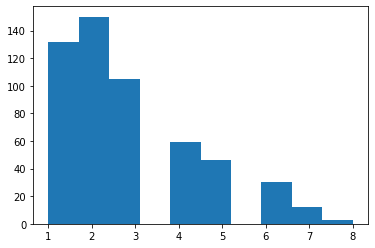

In [51]:
plt.hist(number_of_incorrect_opinions)

#### Average pairwise Hamming distance

In [52]:
from scipy.spatial.distance import hamming
from itertools import combinations

incorrect_distances = []

for model_preds in np.array(a_model_predicts)[bad_questions_mask & incorrect_predictions_mask]:
    pred_distances = []
    for i, j in combinations(range(10), 2):
        pred_distances.append(hamming(model_preds[i], model_preds[j]))
    incorrect_distances.append(np.mean(pred_distances))

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [53]:
np.mean(incorrect_distances)

0.8720758596505638

### Simple Questions

In [54]:
import pickle

entities = np.load('data/candidate_entities_sq_test.npy', allow_pickle=True)

with open('data/entity_subgraphs_sq_test.pickle', 'rb') as handle:
    entity_subgraphs = pickle.load(handle)

In [55]:
sq_candidates = []

for question_entities in entities:
    candidates_dict = {}
    for entity in list(question_entities.item()):
        candidates_dict[entity] = entity_subgraphs[entity]
    sq_candidates.append(candidates_dict)

In [56]:
simple_questions_test = np.load("../new_data/simple_questions_test.npy")

simple_questions_filtered = []
questions_sq = []
answers_sq = []

for e, p, a, q in tqdm(simple_questions_test):
    if e in graph_embeddings_Q and a in graph_embeddings_Q and p in graph_embeddings_P:
        simple_questions_filtered.append((e, p, a, q))
        questions_sq.append(q)
        answers_sq.append([a])

100% 4751/4751 [00:00<00:00, 184007.93it/s]


In [57]:
%autoreload

q_list, a_list, a_predicts, inv_ranks, top1_scores, top2_scores, e_stds, q_stds, p_stds, e_stds_norm, q_stds_norm, p_stds_norm, cosines_stds, entropies_of_mean, mean_entropies, acc, cosines_P_stds, cosines_Q_stds, cosines_E_stds, bad_question_ids, all_cosines, a_model_predicts = eval_ensemble(questions_sq, answers_sq, graph_embeddings_P, graph_embeddings_Q, sq_candidates, mc_models, device)

0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
2438it [04:22,  9.29it/s]

Accuracy:  0.5225594749794914


In [58]:
incorrect_predictions_mask = np.full_like(a_predicts, False)
incorrect_predictions_mask[np.array(inv_ranks) != 1.0] = True
incorrect_predictions_mask = incorrect_predictions_mask.astype(bool)

In [59]:
bad_questions_mask = np.full_like(a_predicts, True)
bad_questions_mask[bad_question_ids] = False
bad_questions_mask = bad_questions_mask.astype(bool)

### All predictions

In [60]:
preds_with_differing_opinions = []
number_of_opinions = []

for model_preds in np.array(a_model_predicts)[bad_questions_mask]:
    first_preds = [pred[0] for pred in model_preds]
    num_opinons = len(set(first_preds))
    number_of_opinions.append(num_opinons)
    preds_with_differing_opinions.append(num_opinons > 1)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.


In [61]:
np.mean(preds_with_differing_opinions)

0.3531583264971288

(array([1577.,  476.,  222.,   86.,    0.,   46.,   20.,    7.,    2.,
           2.]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. , 5.8, 6.6, 7.4, 8.2, 9. ]),
 <BarContainer object of 10 artists>)

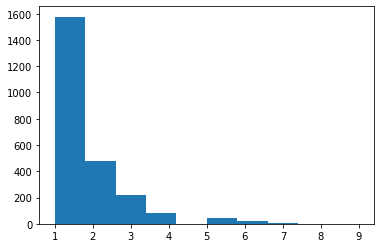

In [62]:
plt.hist(number_of_opinions)

#### Average pairwise Hamming distance

In [63]:
from scipy.spatial.distance import hamming
from itertools import combinations

distances = []

for model_preds in np.array(a_model_predicts)[bad_questions_mask]:
    pred_distances = []
    for i, j in combinations(range(10), 2):
        pred_distances.append(hamming(model_preds[i], model_preds[j]))
    distances.append(np.mean(pred_distances))

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [64]:
np.mean(distances)

0.8780819291778068

### Incorrect predictions

In [65]:
incorrect_preds_with_differing_opinions = []
number_of_incorrect_opinions = []

for model_preds in np.array(a_model_predicts)[bad_questions_mask & incorrect_predictions_mask]:
    first_preds = [pred[0] for pred in model_preds]
    num_opinons = len(set(first_preds))
    number_of_incorrect_opinions.append(num_opinons)
    incorrect_preds_with_differing_opinions.append(num_opinons > 1)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.


In [66]:
np.mean(incorrect_preds_with_differing_opinions)

0.6254295532646048

(array([436., 361., 209.,  81.,   0.,  46.,  20.,   7.,   2.,   2.]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. , 5.8, 6.6, 7.4, 8.2, 9. ]),
 <BarContainer object of 10 artists>)

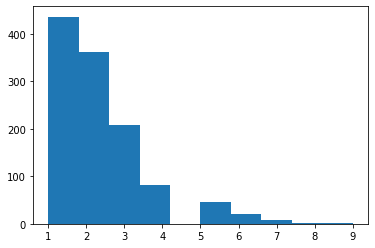

In [67]:
plt.hist(number_of_incorrect_opinions)

#### Average pairwise Hamming distance

In [68]:
from scipy.spatial.distance import hamming
from itertools import combinations

incorrect_distances = []

for model_preds in np.array(a_model_predicts)[bad_questions_mask & incorrect_predictions_mask]:
    pred_distances = []
    for i, j in combinations(range(10), 2):
        pred_distances.append(hamming(model_preds[i], model_preds[j]))
    incorrect_distances.append(np.mean(pred_distances))

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [69]:
np.mean(incorrect_distances)

0.8868607181088438